# Gene Ontology Analysis
# Phase 1 vs. Phase 1
using output from [deseq_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb)

following workflow described [here](https://robertslab.github.io/resources/bio-Annotation/) from the Roberts Lab

## 0. load libraries

In [2]:
library(GSEABase)
library(GO.db)
library(tidyverse)
library(patchwork)

## 1. Map GO IDs to gene IDs

In [3]:
# read in gene ID to GO file
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


## 2. Create `gene2goSlim` function
to reduce code redundancy

**code is taken directly from Roberts Lab Annotation Handbook** - see [here](https://robertslab.github.io/resources/bio-Annotation/#map-go-ids-to-goslims)
- but this is slightly modified to allow the user to input which GO processes they want to get returned (BP, MF, or CC)

see bottom of code notebook for outputs of various parts of this function

In [4]:
gene2goSlim <- function(gene2go, deg_df, ontology = "BP") {

    gene_go <- left_join(deg_df, gene2go, by = "gene")

colnames(gene_go) <- c('gene_id', 'Gene.Ontology.IDs')
    
# Column names corresponding to gene name/ID and GO IDs
GO.ID.column <- "Gene.Ontology.IDs"
gene.ID.column <- "gene_id"

# Relative path or URL to input file
### BOTH vs. CONTROL
input.file <- gene_go

##### Official GO info - no need to change #####
goslims_obo <- "goslim_generic.obo"
goslims_url <- "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"

# Find GSEAbase installation location
gseabase_location <- find.package("GSEABase")

# Load path to GOslim OBO file
goslim_obo_destintation <- file.path(gseabase_location, "extdata", goslims_obo, fsep = "/")

# Download the GOslim OBO file
download.file(url = goslims_url, destfile = goslim_obo_destintation)

# Loads package files
gseabase_files <- system.file("extdata", goslims_obo, package="GSEABase")

# read in gene file
#full.gene.df <- read.csv(file = input.file, header = TRUE, sep = ",")
full.gene.df <- gene_go

# Clean whitespace, filter NA/empty rows, select columns, and split GO terms using column name variables
gene.GO.df <- full.gene.df %>%
  mutate(!!GO.ID.column := str_replace_all(.data[[GO.ID.column]], "\\s*;\\s*", ";")) %>% # Clean up spaces around ";"
  filter(!is.na(.data[[gene.ID.column]]) & !is.na(.data[[GO.ID.column]]) & .data[[GO.ID.column]] != "") %>% 
  select(all_of(c(gene.ID.column, GO.ID.column)))

# flatten file
flat.gene.GO.df <- gene.GO.df %>% separate_rows(!!sym(GO.ID.column), sep = ";")

# group genes by GO.ID
grouped.gene.GO.df <- flat.gene.GO.df %>%
  group_by(!!sym(GO.ID.column)) %>%
  summarise(!!gene.ID.column := paste(.data[[gene.ID.column]], collapse = ","))

# Vector of GO IDs
go_ids <- grouped.gene.GO.df[[GO.ID.column]]

# create new OBO collection object of just GOslims, based on provided GO IDs
# Create GSEAbase GOCollection using `go_ids`
myCollection <- GOCollection(go_ids)

# Retrieve GOslims from GO OBO file set
slim <- getOBOCollection(gseabase_files)

# Retrieve Biological Process (BP) GOslims
slimdf <- goSlim(myCollection, slim, ontology, verbose = verbose)

# construct the offspring name dynamically
offspring_name <- switch(ontology,
                         BP = 'GOBPOFFSPRING',
                         MF = 'GOMFOFFSPRING',
                         CC = 'GOCCOFFSPRING')

# retrieve correct offspring object
offspring_obj <- get(offspring_name)
    
# List of GOslims and all GO IDs from `go_ids`
gomap <- as.list(offspring_obj[rownames(slimdf)])

# Maps `go_ids` to matching GOslims
mapped <- lapply(gomap, intersect, ids(myCollection))

# Append all mapped GO IDs to `slimdf`
# `sapply` needed to apply paste() to create semi-colon delimited values
slimdf$GO.IDs <- sapply(lapply(gomap, intersect, ids(myCollection)), paste, collapse=";")

# Remove "character(0) string from "GO.IDs" column
slimdf$GO.IDs[slimdf$GO.IDs == "character(0)"] <- ""

# Add self-matching GOIDs to "GO.IDs" column, if not present
for (go_id in go_ids) {
  # Check if the go_id is present in the row names
  if (go_id %in% rownames(slimdf)) {
    # Check if the go_id is not present in the GO.IDs column
    # Also removes white space "trimws()" and converts all to upper case to handle
    # any weird, "invisible" formatting issues.
    if (!go_id %in% trimws(toupper(strsplit(slimdf[go_id, "GO.IDs"], ";")[[1]]))) {
      # Append the go_id to the GO.IDs column with a semi-colon separator
      if (length(slimdf$GO.IDs) > 0 && nchar(slimdf$GO.IDs[nrow(slimdf)]) > 0) {
        slimdf[go_id, "GO.IDs"] <- paste0(slimdf[go_id, "GO.IDs"], "; ", go_id)
      } else {
        slimdf[go_id, "GO.IDs"] <- go_id
      }
    }
  }
}

# "Flatten" file so each row is single GO ID with corresponding GOslim
# rownames_to_column needed to retain row name info
slimdf_separated <- as.data.frame(slimdf %>%
  rownames_to_column('GOslim') %>%
  separate_rows(GO.IDs, sep = ";"))

# Group by unique GO ID
grouped_slimdf <- slimdf_separated %>%
  filter(!is.na(GO.IDs) & GO.IDs != "") %>%
  group_by(GO.IDs) %>%
  summarize(GOslim = paste(GOslim, collapse = ";"),
            Term = paste(Term, collapse = ";"))

slimdf.sorted <- slimdf %>% arrange(desc(Count))

slim.count.df <- slimdf.sorted %>% 
  select(Term, Count)

return(slim.count.df)

    }

## Phase 1 Both vs. Control

In [9]:
# read in DEG file

## BOTH vs. CONTROL
b.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_both_v_cont.csv') %>%
select(X)

colnames(b.c_deg) <- c('gene')
head(b.c_deg)

,gene
,<chr>
1,LOC111119645
2,LOC111111234
3,LOC111104630
4,LOC111100092
5,LOC111129171
6,LOC111121183


In [42]:
# biological processes
b.c_goSlim.BP <- gene2goSlim(gene2go,b.c_deg, "BP")
head(b.c_goSlim.BP, 2)

# molecular function
b.c_goSlim.MF <- gene2goSlim(gene2go,b.c_deg, "MF")
head(b.c_goSlim.MF, 2)

# biological processes
b.c_goSlim.CC <- gene2goSlim(gene2go,b.c_deg, "CC")
head(b.c_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,107
GO:0030154,cell differentiation,47


,Term,Count
,<chr>,<int>
GO:0003824,catalytic activity,75
GO:0016787,hydrolase activity,41


,Term,Count
,<chr>,<int>
GO:0043226,organelle,87
GO:0005886,plasma membrane,23


In [43]:
bc.BP.top20 <- b.c_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

bc.MF.top20 <- b.c_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

bc.CC.top20 <- b.c_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

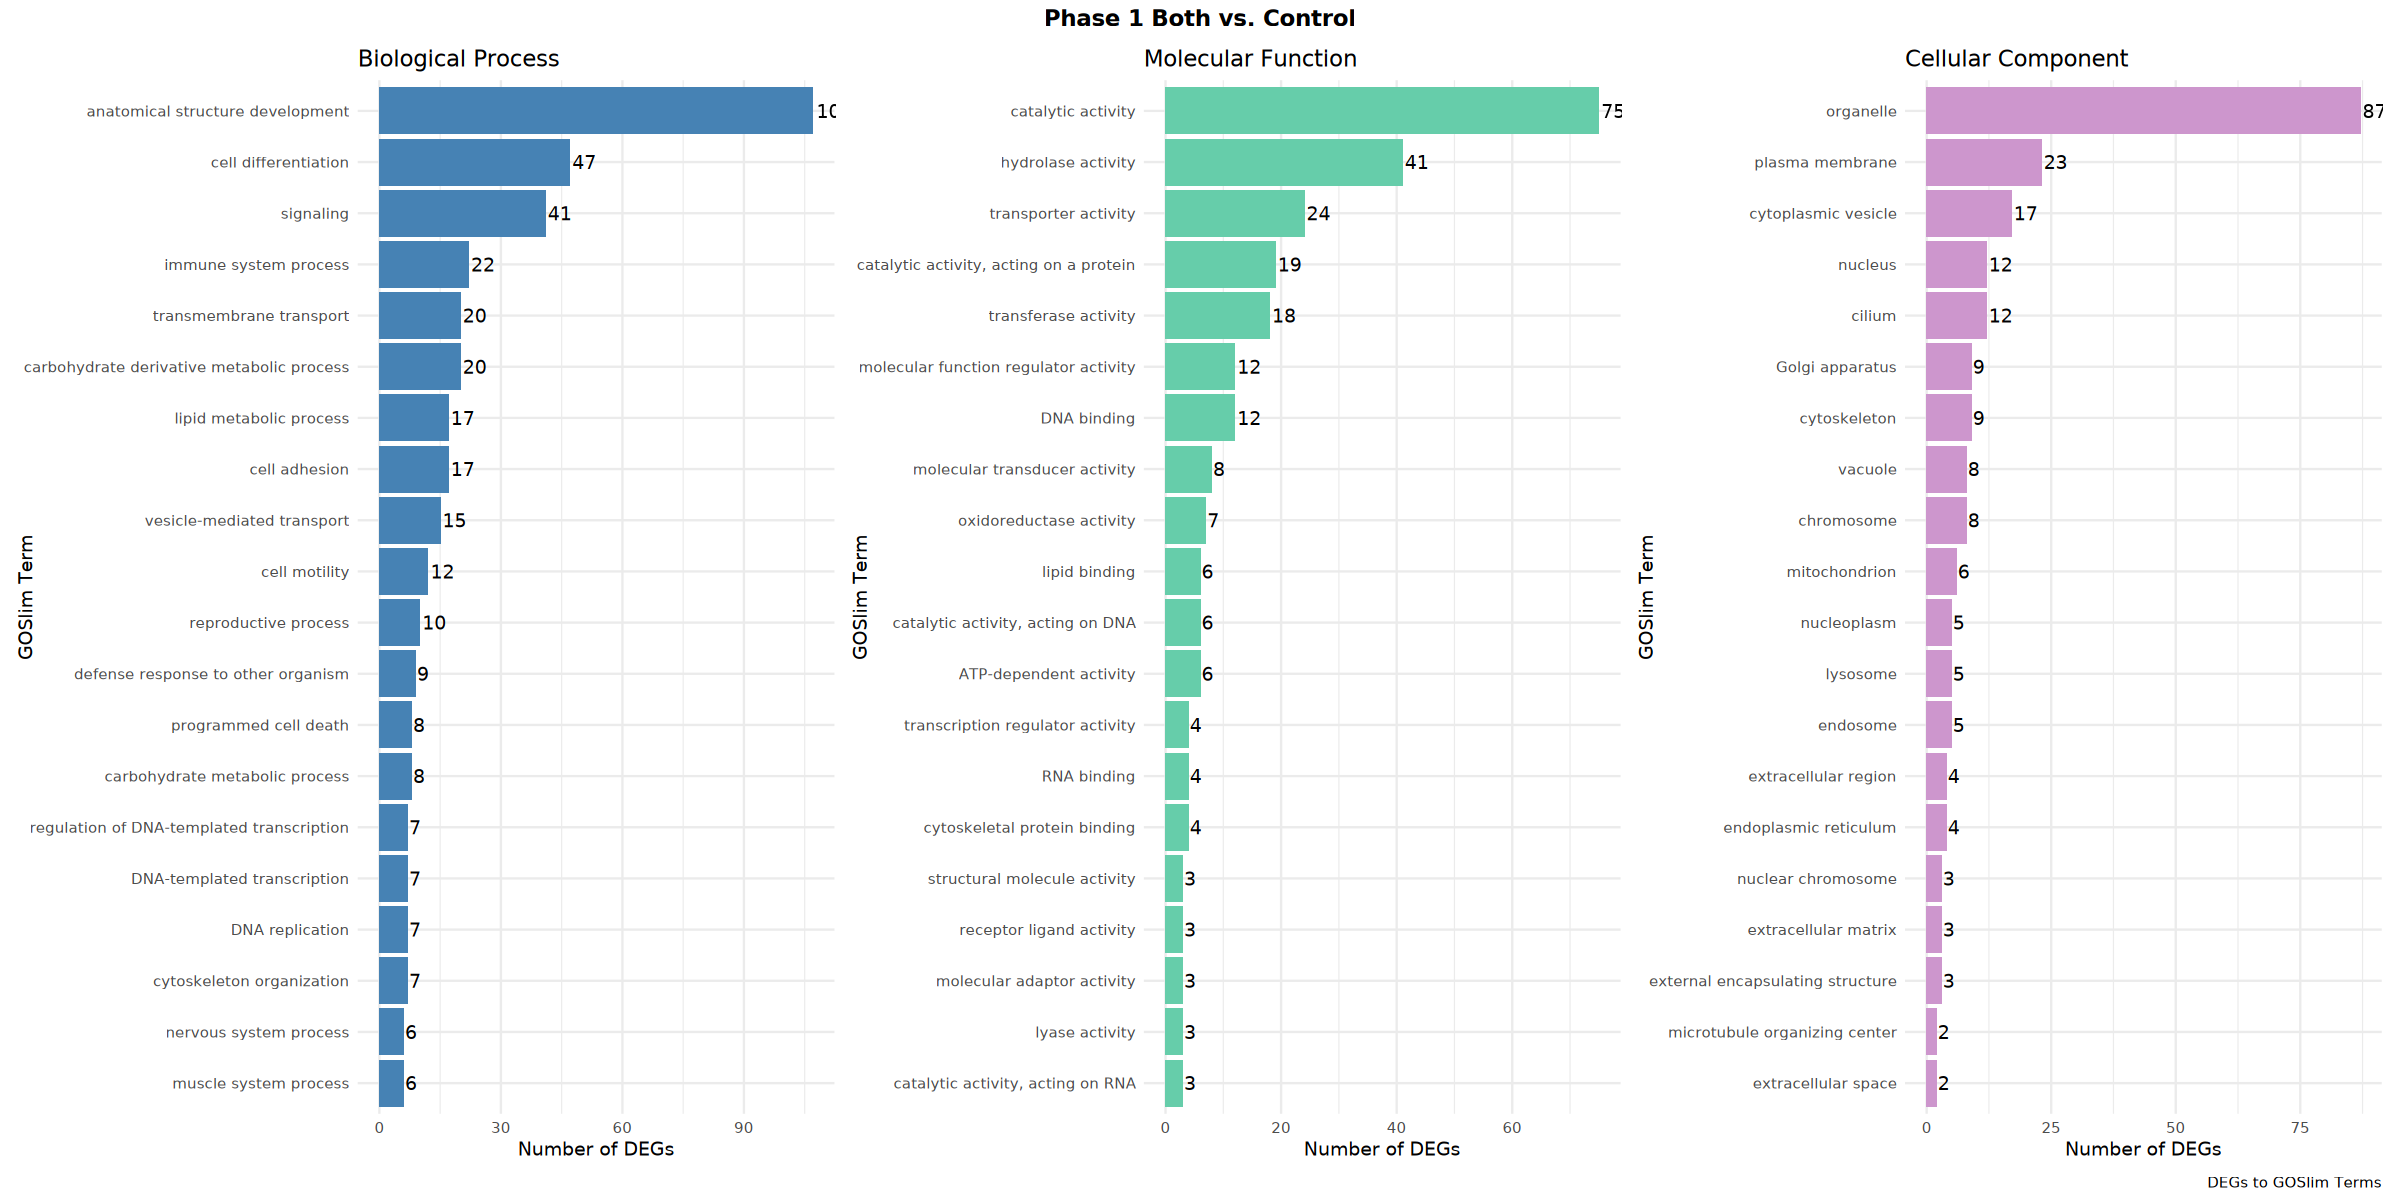

In [44]:
options(repr.plot.width=20, repr.plot.height=10)

bc.bp.topPlot <- ggplot(bc.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

bc.mf.topPlot <- ggplot(bc.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

bc.cc.topPlot <- ggplot(bc.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

bc.bp.topPlot + bc.mf.topPlot + bc.cc.topPlot + plot_annotation('Phase 1 Both vs. Control',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

## Phase 1 Warm vs. Control

In [34]:
# read in DEG file

## WARM vs. CONTROL
w.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_cont.csv') %>%
select(X)

colnames(w.c_deg) <- c('gene')
head(w.c_deg)

,gene
,<chr>
1,LOC111130870
2,LOC111129171
3,LOC111121183
4,LOC111106303
5,LOC111122541
6,LOC111130453


In [38]:
# biological process
w.c_goSlim.BP <- gene2goSlim(gene2go,w.c_deg, 'BP')
head(w.c_goSlim.BP, 2)

# molecular function
w.c_goSlim.MF <- gene2goSlim(gene2go,w.c_deg, 'MF')
head(w.c_goSlim.MF, 2)

# cellular component
w.c_goSlim.CC <- gene2goSlim(gene2go,w.c_deg, 'CC')
head(w.c_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0002376,immune system process,19
GO:0023052,signaling,17


,Term,Count
,<chr>,<int>
GO:0003824,catalytic activity,17
GO:0098772,molecular function regulator activity,5


,Term,Count
,<chr>,<int>
GO:0043226,organelle,31
GO:0005886,plasma membrane,15


In [39]:
wc.BP.top20 <- w.c_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

wc.MF.top20 <- w.c_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

wc.CC.top20 <- w.c_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

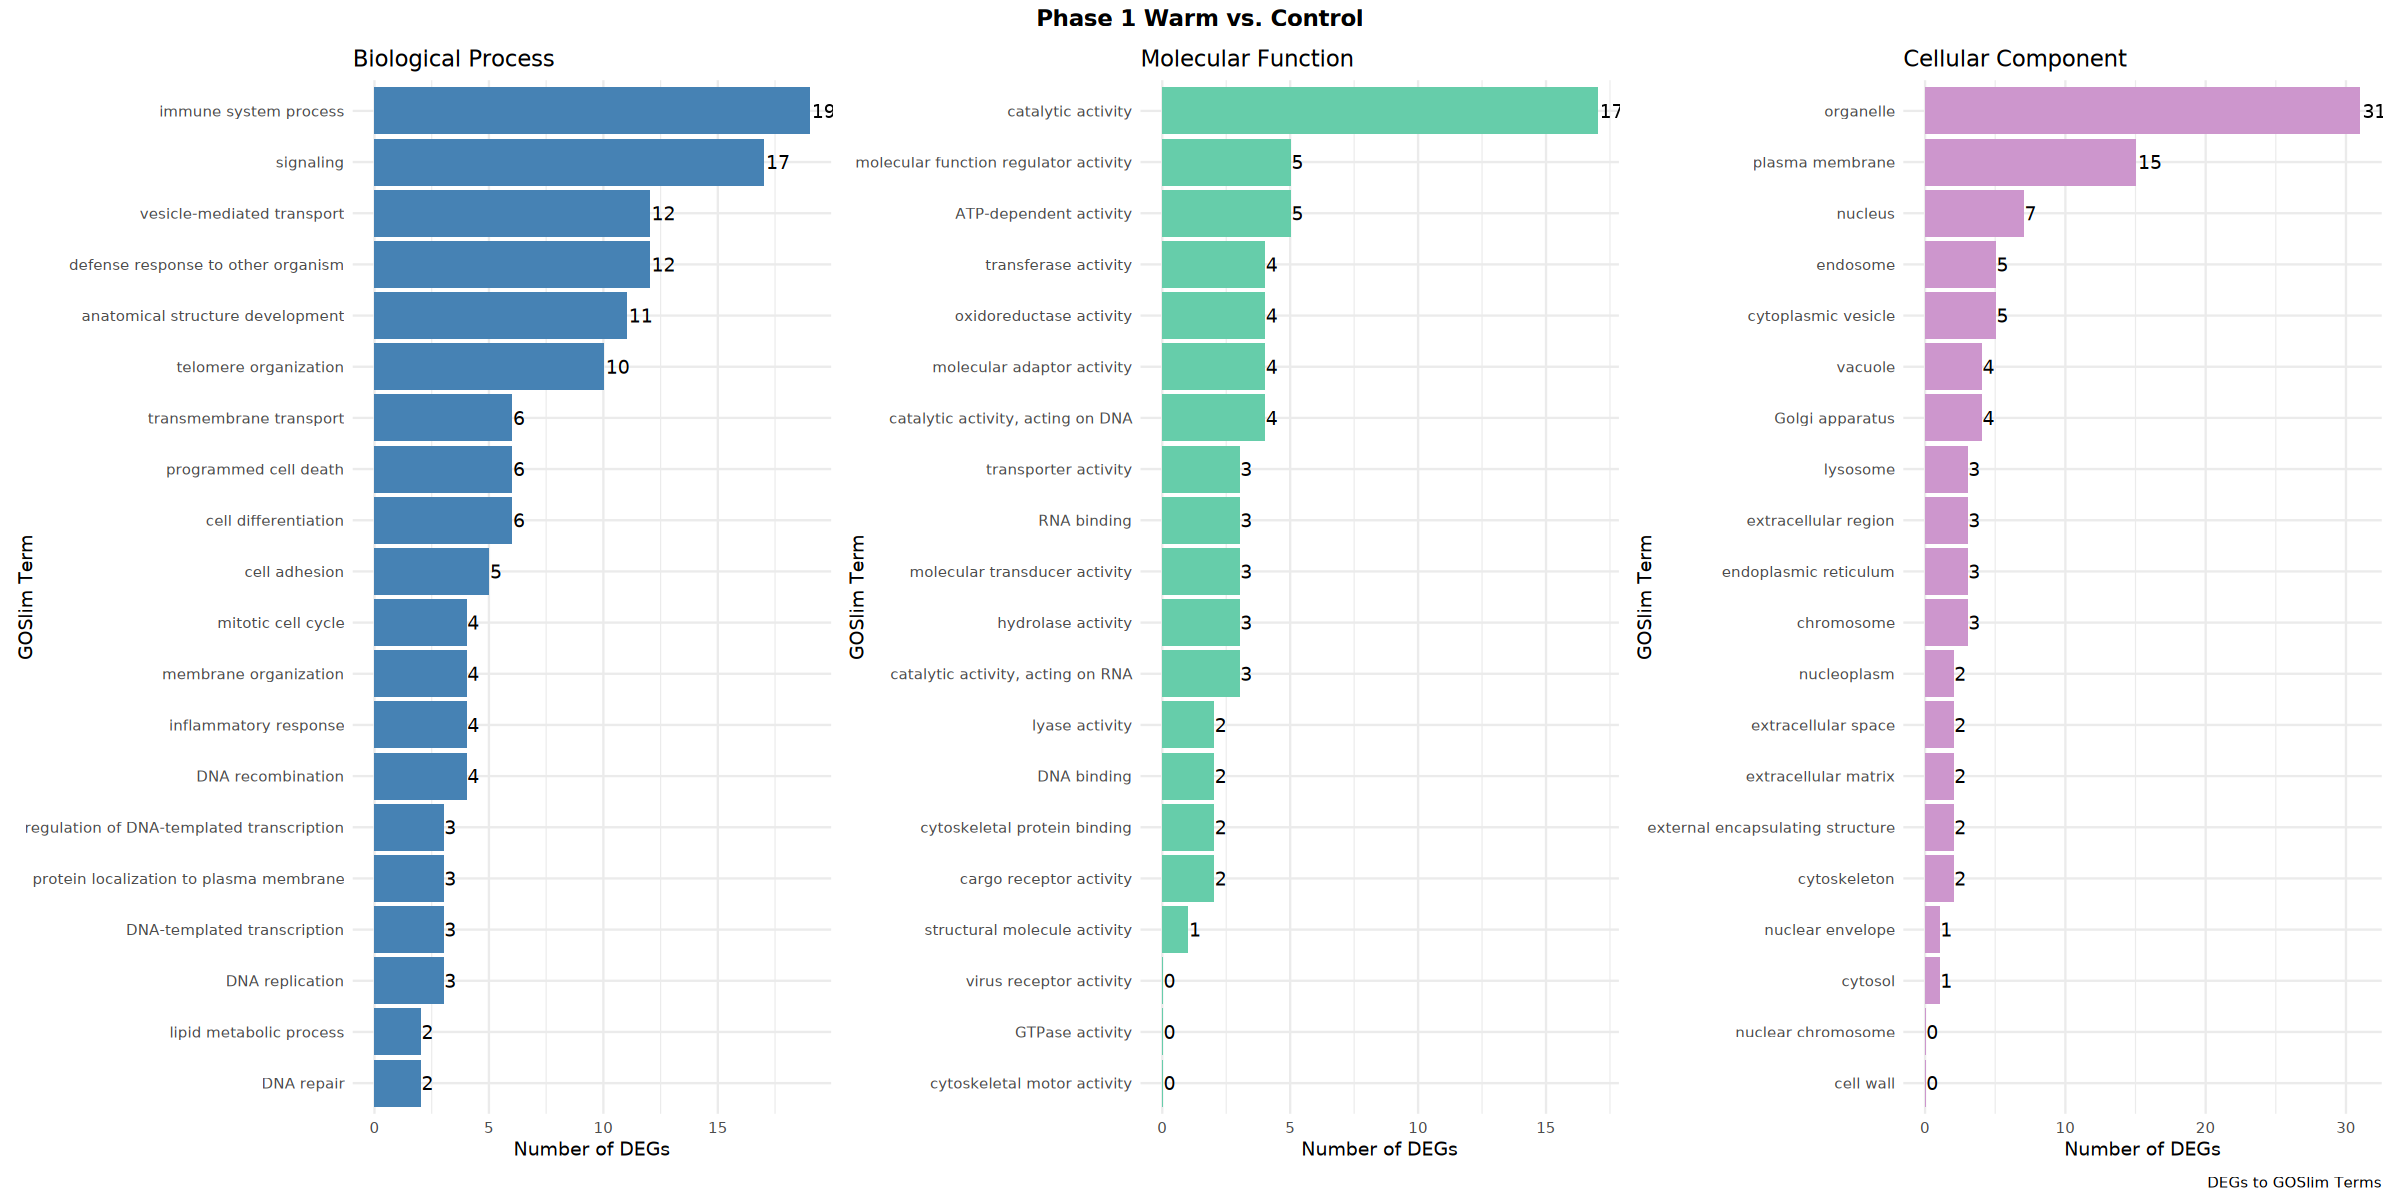

In [40]:
options(repr.plot.width=20, repr.plot.height=10)

wc.bp.topPlot <- ggplot(wc.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wc.mf.topPlot <- ggplot(wc.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wc.cc.topPlot <- ggplot(wc.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wc.bp.topPlot + wc.mf.topPlot + wc.cc.topPlot + plot_annotation('Phase 1 Warm vs. Control',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

## Phase 1 Hypoxic vs. Control

In [46]:
# read in DEG file

## HYPOXIC vs. CONTROL
h.c_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_hyp_v_cont.csv') %>%
select(X)

colnames(h.c_deg) <- c('gene')
head(h.c_deg)

,gene
,<chr>
1,LOC111121183
2,LOC111120021
3,LOC111119724
4,LOC111119726
5,LOC111121216
6,LOC111125414


In [53]:
# biological process
h.c_goSlim.BP <- gene2goSlim(gene2go,h.c_deg, 'BP')
head(h.c_goSlim.BP, 2)

# molecular function
h.c_goSlim.MF <- gene2goSlim(gene2go,h.c_deg, 'MF')
head(h.c_goSlim.MF, 2)

# cellular component
h.c_goSlim.CC <- gene2goSlim(gene2go,h.c_deg, 'CC')
head(h.c_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0016192,vesicle-mediated transport,6
GO:0055085,transmembrane transport,5


,Term,Count
,<chr>,<int>
GO:0005215,transporter activity,3
GO:0003723,RNA binding,2


,Term,Count
,<chr>,<int>
GO:0043226,organelle,17
GO:0005886,plasma membrane,10


In [48]:
hc.BP.top20 <- h.c_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

hc.MF.top20 <- h.c_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

hc.CC.top20 <- h.c_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

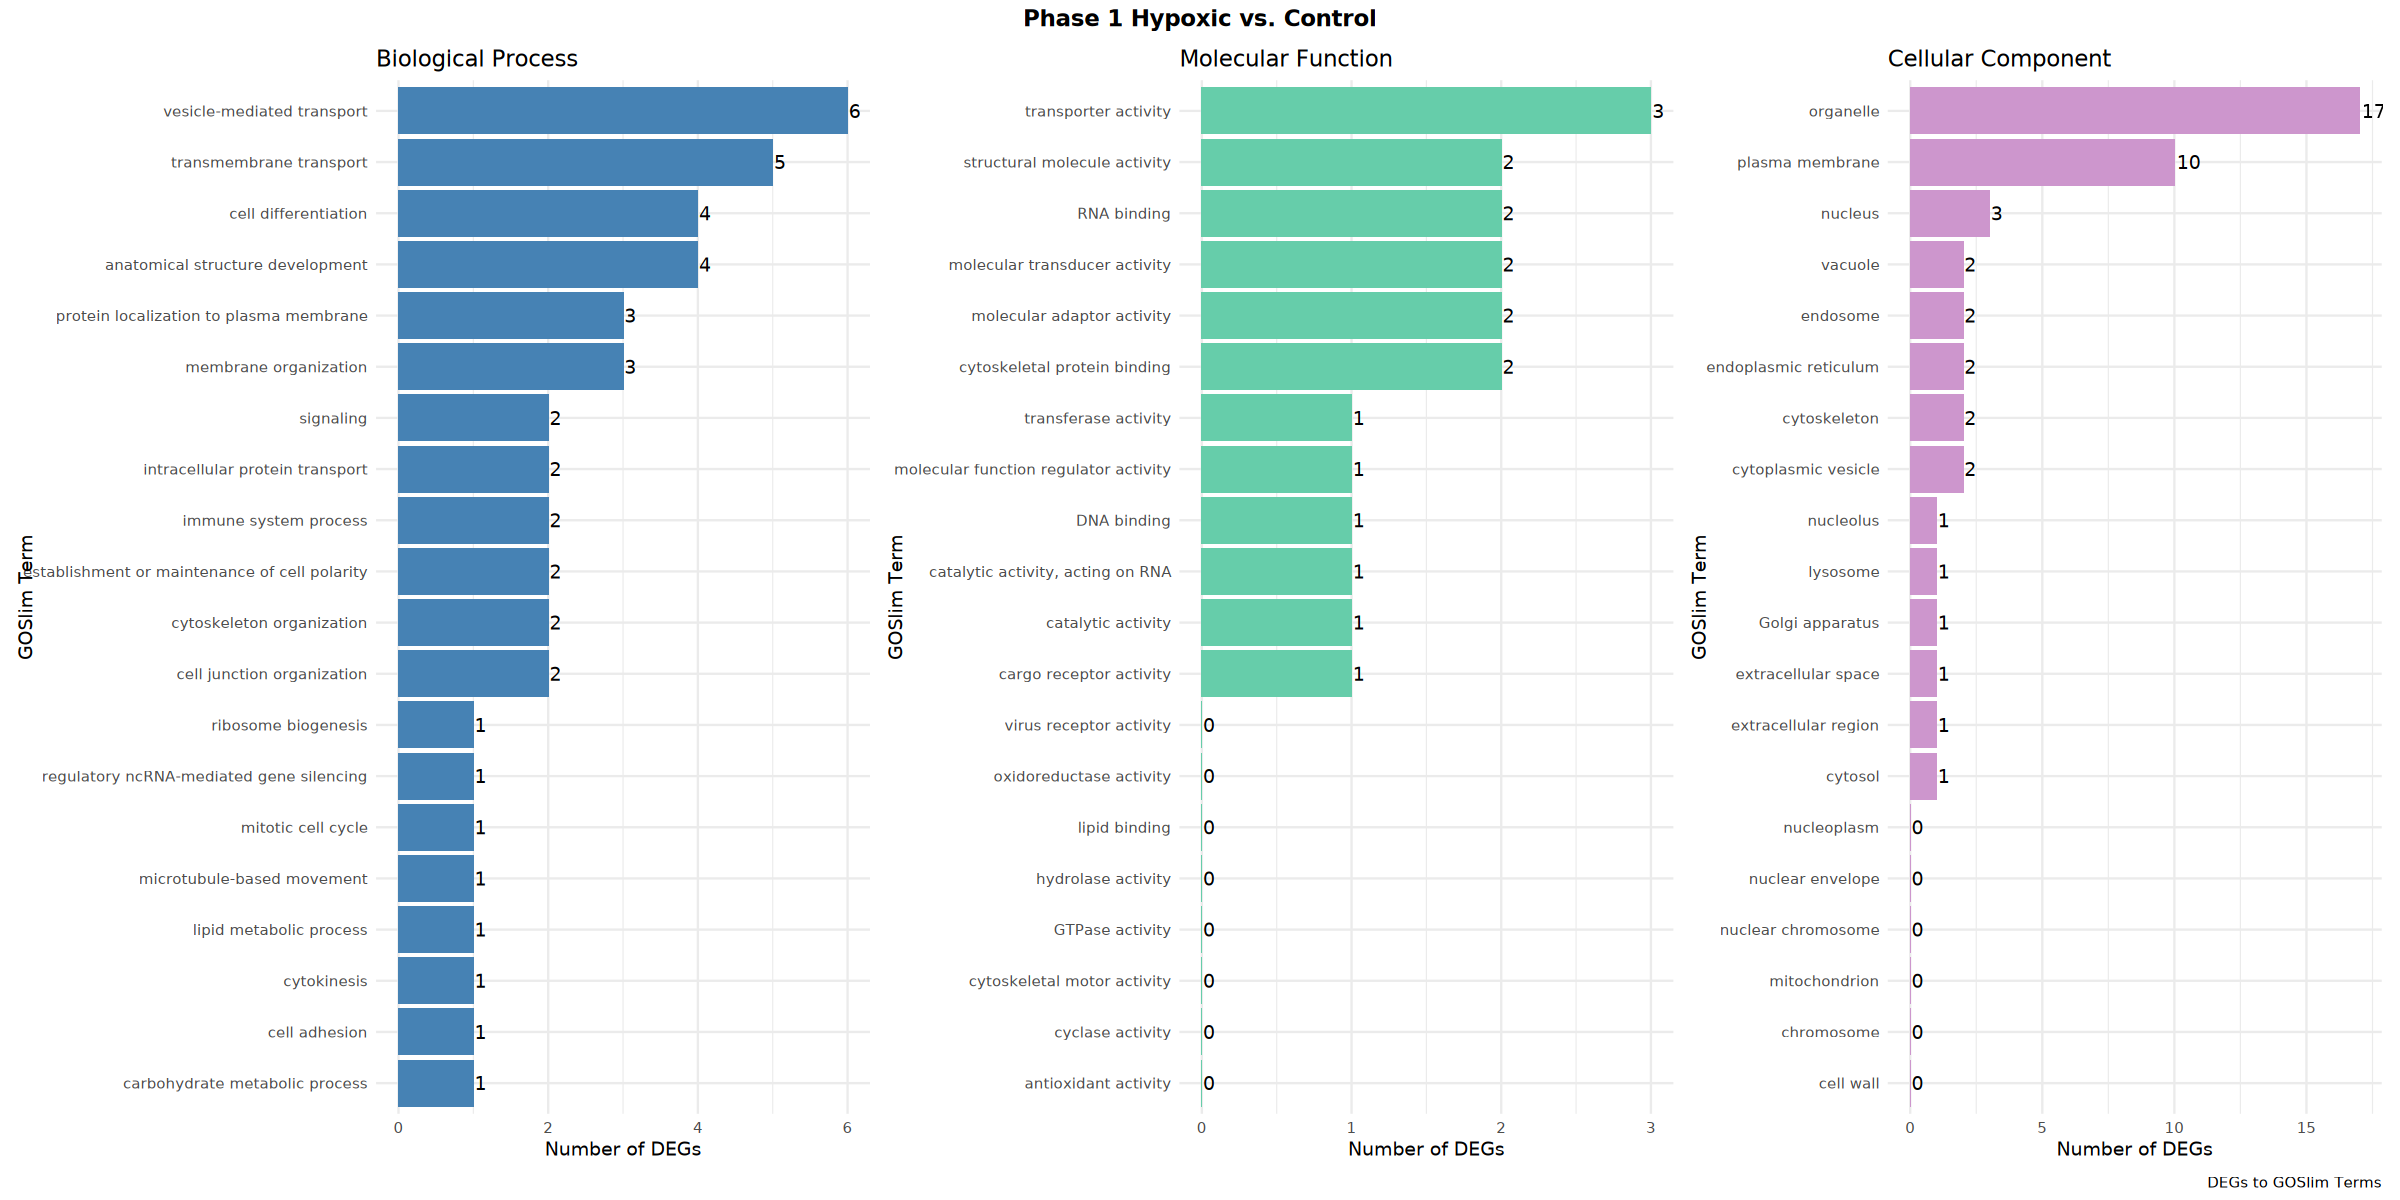

In [49]:
options(repr.plot.width=20, repr.plot.height=10)

hc.bp.topPlot <- ggplot(hc.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

hc.mf.topPlot <- ggplot(hc.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

hc.cc.topPlot <- ggplot(hc.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

hc.bp.topPlot + hc.mf.topPlot + hc.cc.topPlot + plot_annotation('Phase 1 Hypoxic vs. Control',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

## comparisons outside those with control
## Phase 1 Warm vs. Hypoxic

In [5]:
# read in DEG file

## WARM vs. HYPOXIC
w.h_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_hyp.csv') %>%
select(X)

colnames(w.h_deg) <- c('gene')
head(w.h_deg)

,gene
,<chr>
1,LOC111112448
2,LOC111113921
3,LOC111110198
4,LOC111129171
5,LOC111103459
6,LOC111135260


In [6]:
# biological process
w.h_goSlim.BP <- gene2goSlim(gene2go,w.h_deg, 'BP')
head(w.h_goSlim.BP, 2)

# molecular function
w.h_goSlim.MF <- gene2goSlim(gene2go,w.h_deg, 'MF')
head(w.h_goSlim.MF, 2)

# cellular component
w.h_goSlim.CC <- gene2goSlim(gene2go,w.h_deg, 'CC')
head(w.h_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,15
GO:0023052,signaling,11


,Term,Count
,<chr>,<int>
GO:0003824,catalytic activity,15
GO:0016787,hydrolase activity,7


,Term,Count
,<chr>,<int>
GO:0043226,organelle,29
GO:0005886,plasma membrane,10


In [7]:
wh.BP.top20 <- w.h_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

wh.MF.top20 <- w.h_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

wh.CC.top20 <- w.h_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

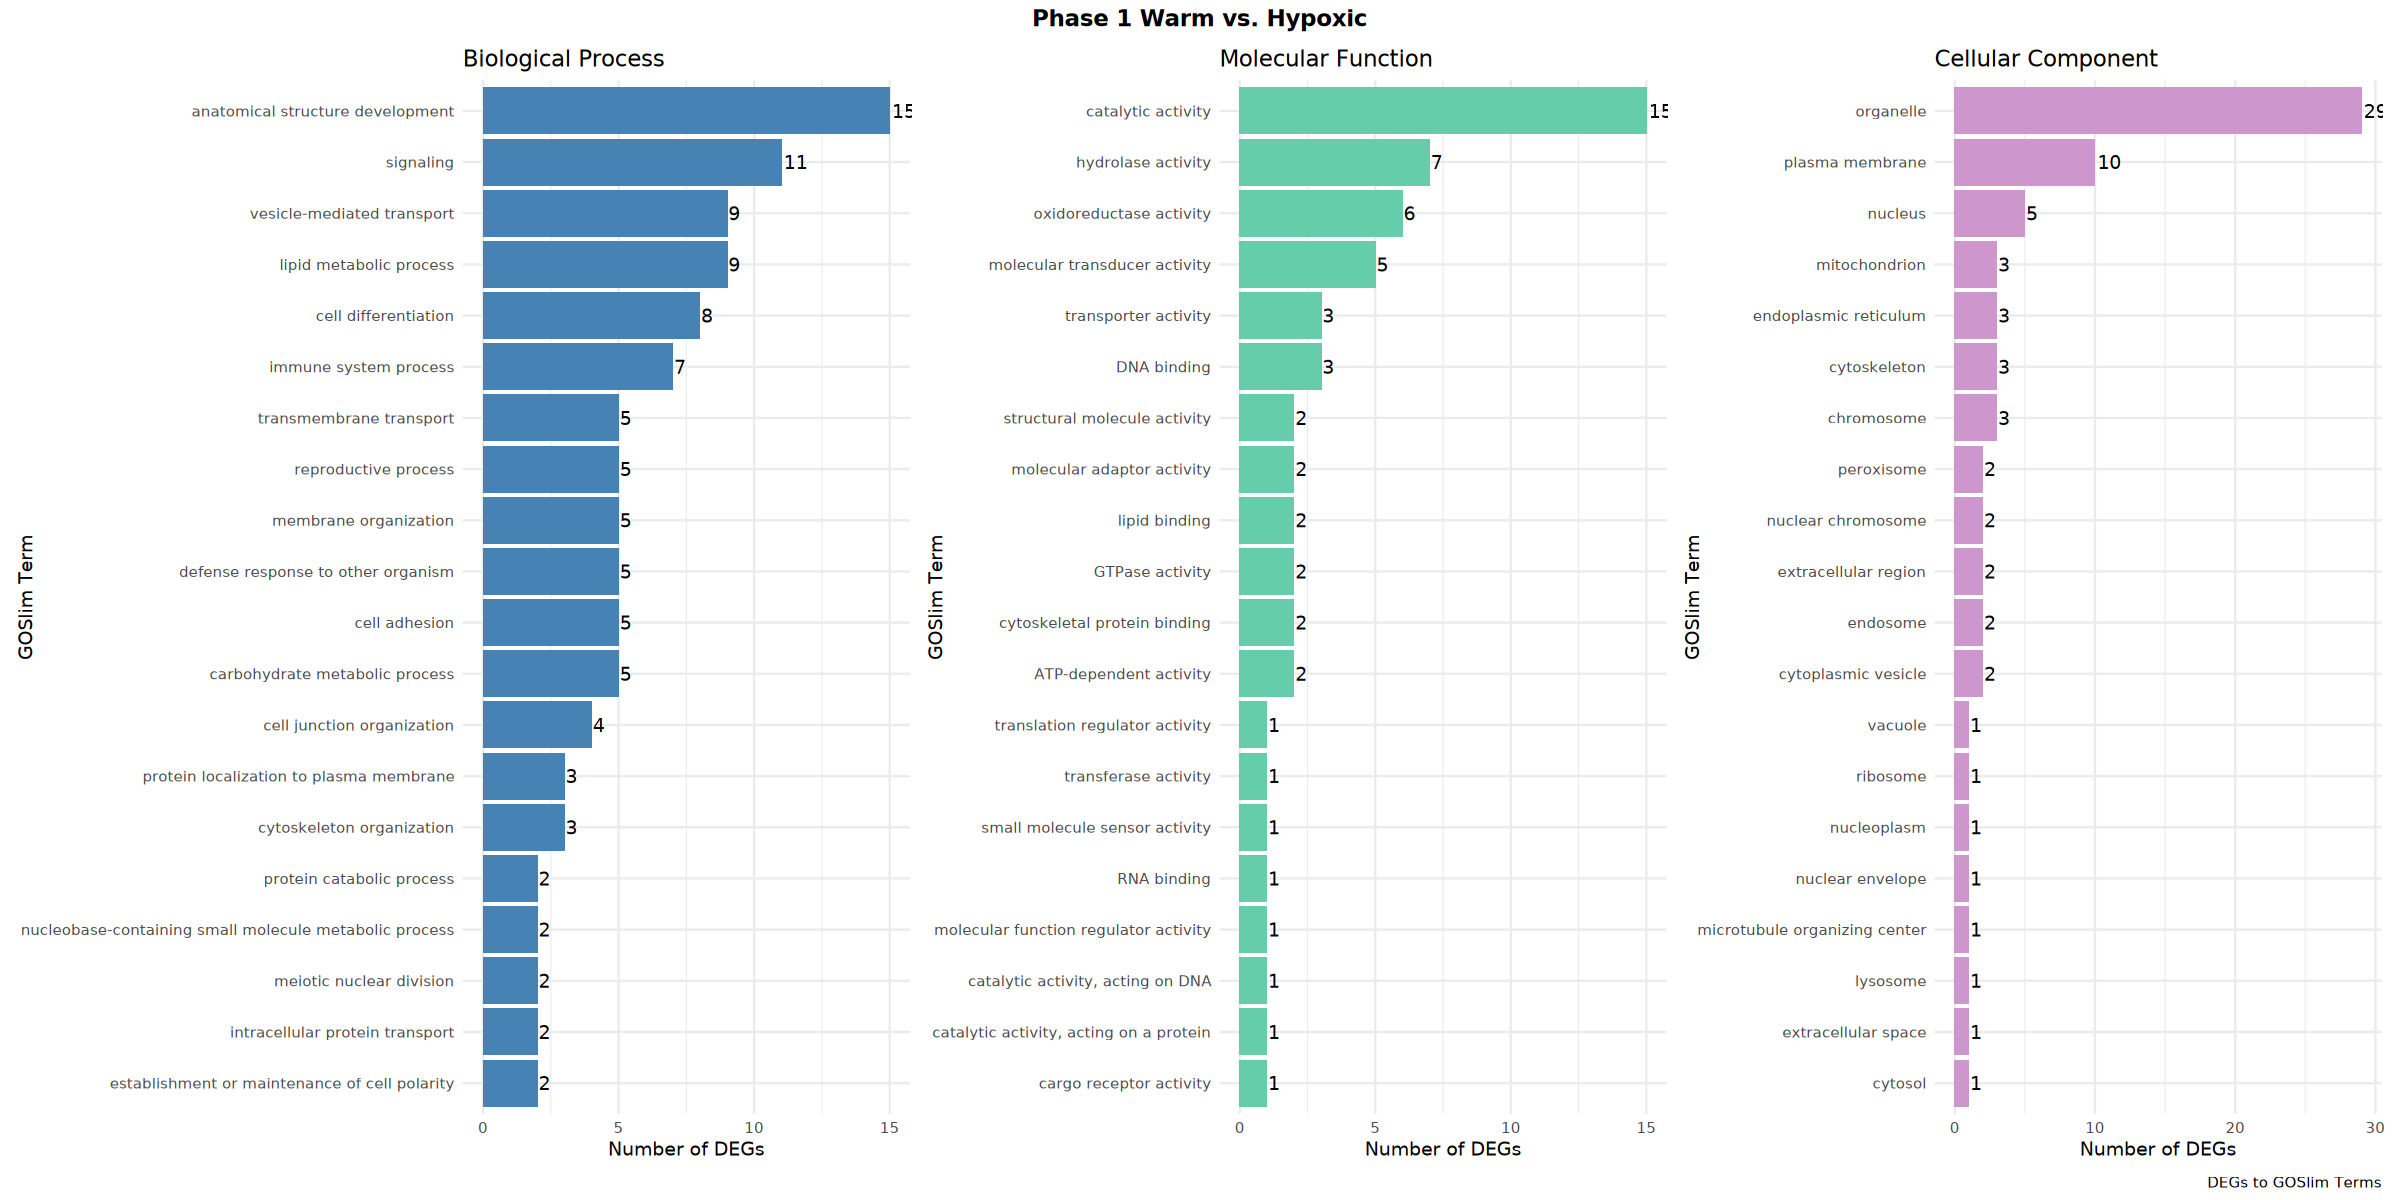

In [8]:
options(repr.plot.width=20, repr.plot.height=10)

wh.bp.topPlot <- ggplot(wh.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wh.mf.topPlot <- ggplot(wh.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wh.cc.topPlot <- ggplot(wh.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wh.bp.topPlot + wh.mf.topPlot + wh.cc.topPlot + plot_annotation('Phase 1 Warm vs. Hypoxic',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

## Phase 1 Warm vs. Both

In [56]:
# read in DEG file

## WARM vs. BOTH
w.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_warm_v_both.csv') %>%
select(X)

colnames(w.b_deg) <- c('gene')
head(w.b_deg)

,gene
,<chr>
1,LOC111119645
2,LOC111106320
3,LOC111115327
4,LOC111102200
5,LOC111105368
6,LOC111134528


In [57]:
# biological process
w.b_goSlim.BP <- gene2goSlim(gene2go,w.b_deg, 'BP')
head(w.b_goSlim.BP, 2)

# molecular function
w.b_goSlim.MF <- gene2goSlim(gene2go,w.b_deg, 'MF')
head(w.b_goSlim.MF, 2)

# cellular component
w.b_goSlim.CC <- gene2goSlim(gene2go,w.b_deg, 'CC')
head(w.b_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,70
GO:0030154,cell differentiation,29


,Term,Count
,<chr>,<int>
GO:0003824,catalytic activity,44
GO:0016787,hydrolase activity,26


,Term,Count
,<chr>,<int>
GO:0043226,organelle,51
GO:0005886,plasma membrane,16


In [58]:
wb.BP.top20 <- w.b_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

wb.MF.top20 <- w.b_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

wb.CC.top20 <- w.b_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

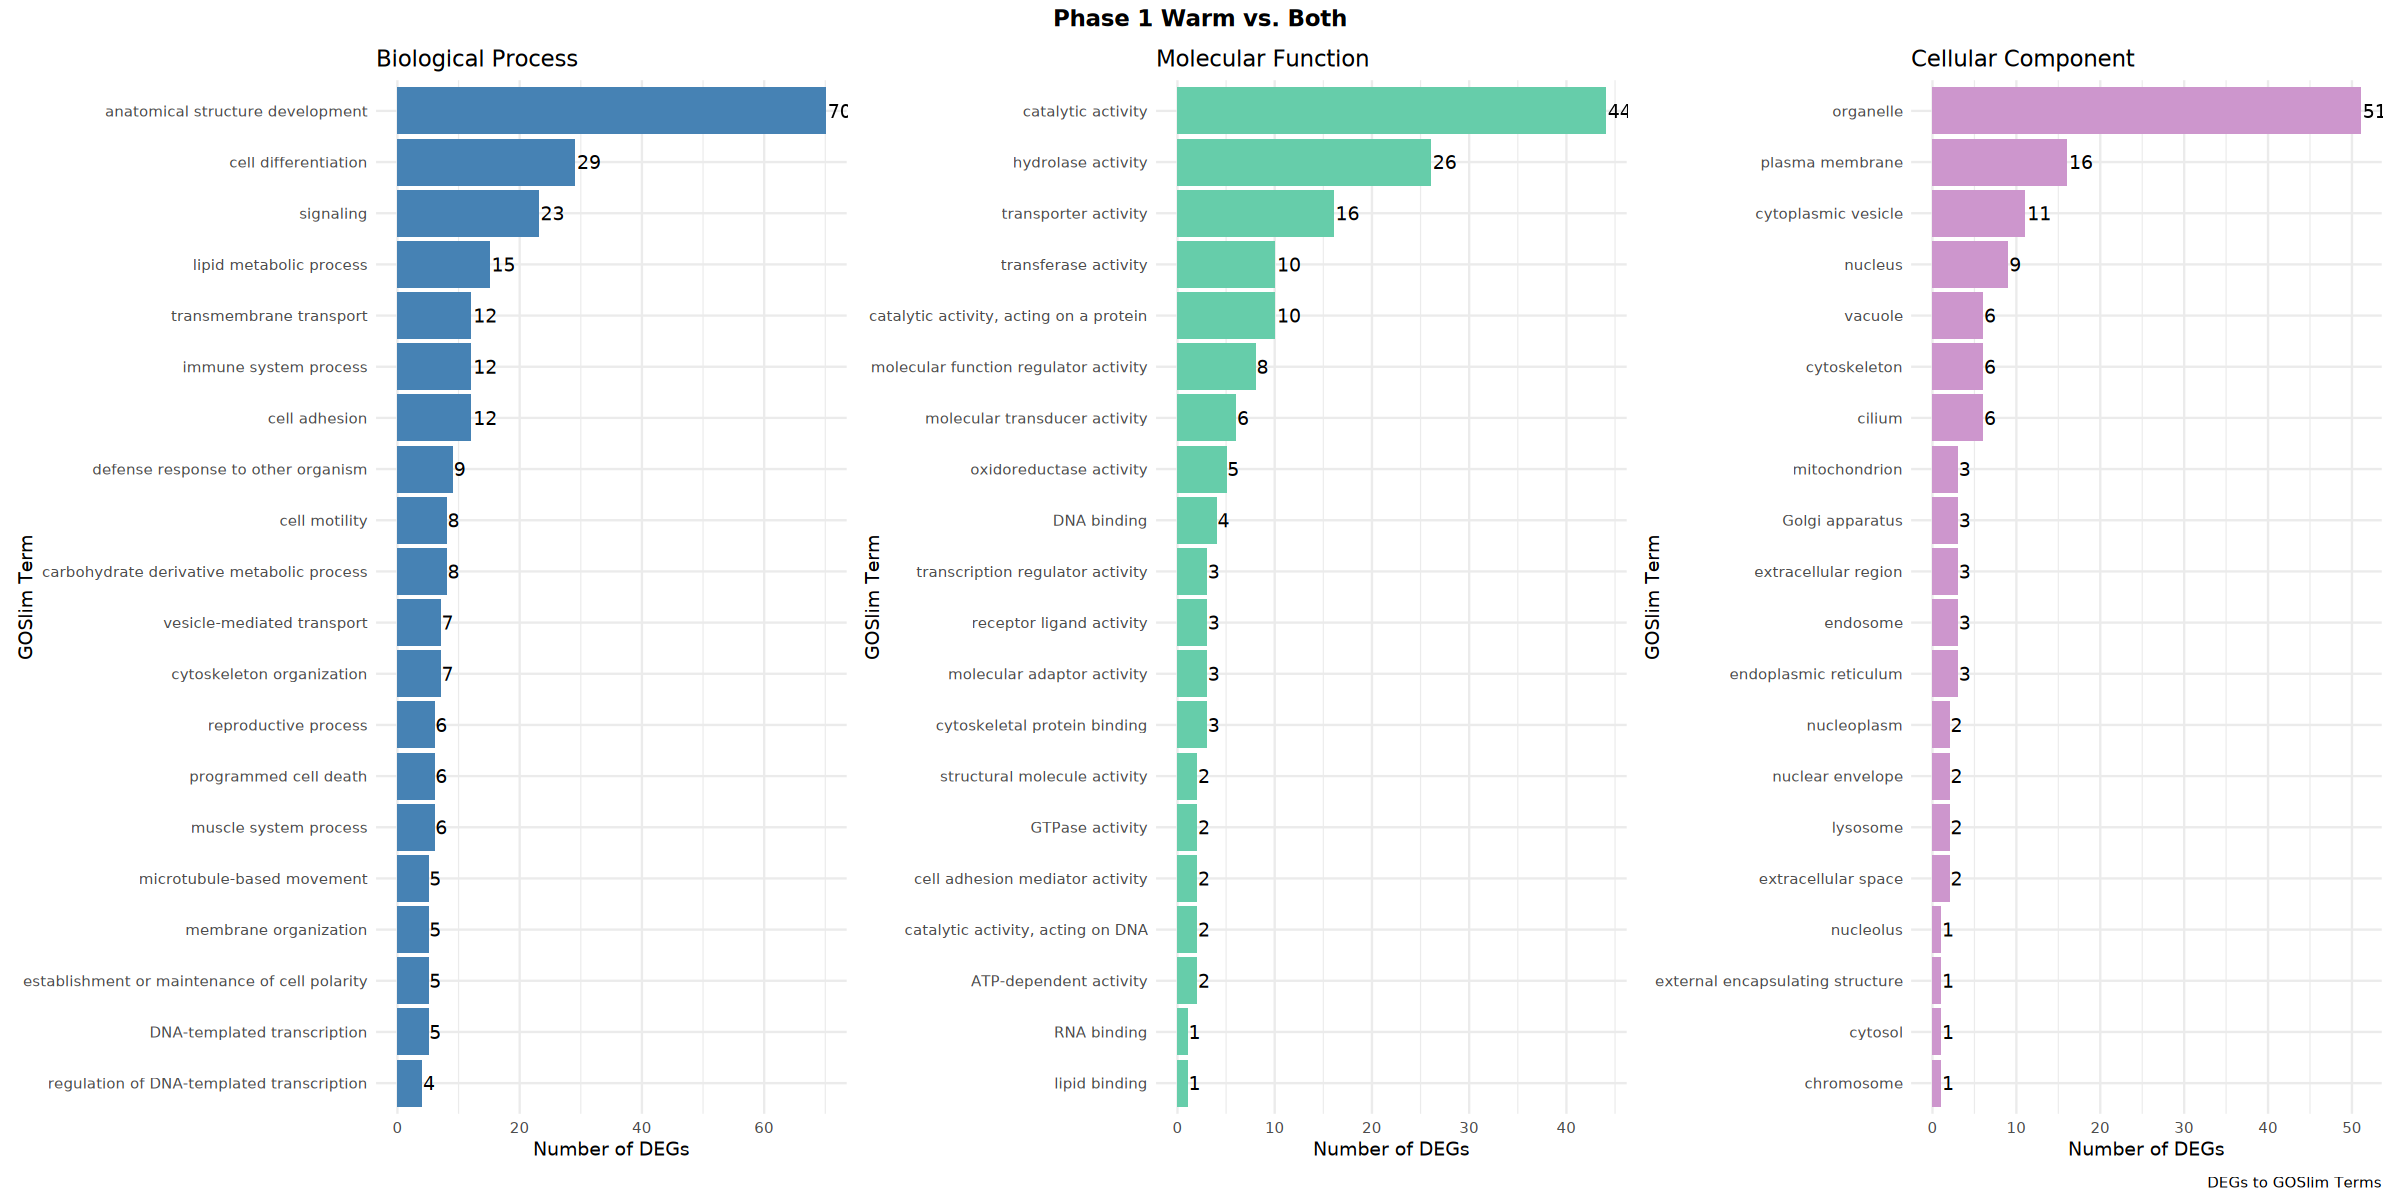

In [59]:
options(repr.plot.width=20, repr.plot.height=10)

wb.bp.topPlot <- ggplot(wb.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wb.mf.topPlot <- ggplot(wb.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wb.cc.topPlot <- ggplot(wb.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

wb.bp.topPlot + wb.mf.topPlot + wb.cc.topPlot + plot_annotation('Phase 1 Warm vs. Both',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

## Phase 1 Hypoxic vs. Both

In [60]:
# read in DEG file

## BOTH vs. CONTROL
h.b_deg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1.DEG_hyp_v_both.csv') %>%
select(X)

colnames(h.b_deg) <- c('gene')
head(h.b_deg)

,gene
,<chr>
1,LOC111119645
2,LOC111103382
3,LOC111104182
4,LOC111129171
5,LOC111111721
6,LOC111111747


In [62]:
# biological process
h.b_goSlim.BP <- gene2goSlim(gene2go,h.b_deg, 'BP')
head(h.b_goSlim.BP, 2)

# molecular function
h.b_goSlim.MF <- gene2goSlim(gene2go,h.b_deg, 'MF')
head(h.b_goSlim.MF, 2)

# cellular component
h.b_goSlim.CC <- gene2goSlim(gene2go,h.b_deg, 'CC')
head(h.b_goSlim.CC, 2)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,59
GO:0030154,cell differentiation,27


,Term,Count
,<chr>,<int>
GO:0003824,catalytic activity,46
GO:0016787,hydrolase activity,27


,Term,Count
,<chr>,<int>
GO:0043226,organelle,39
GO:0005886,plasma membrane,21


In [63]:
hb.BP.top20 <- h.b_goSlim.BP %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

hb.MF.top20 <- h.b_goSlim.MF %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

hb.CC.top20 <- h.b_goSlim.CC %>%
  arrange(desc(Count)) %>% # order from most to least
slice_head(n = 20)         # take top 20 rows

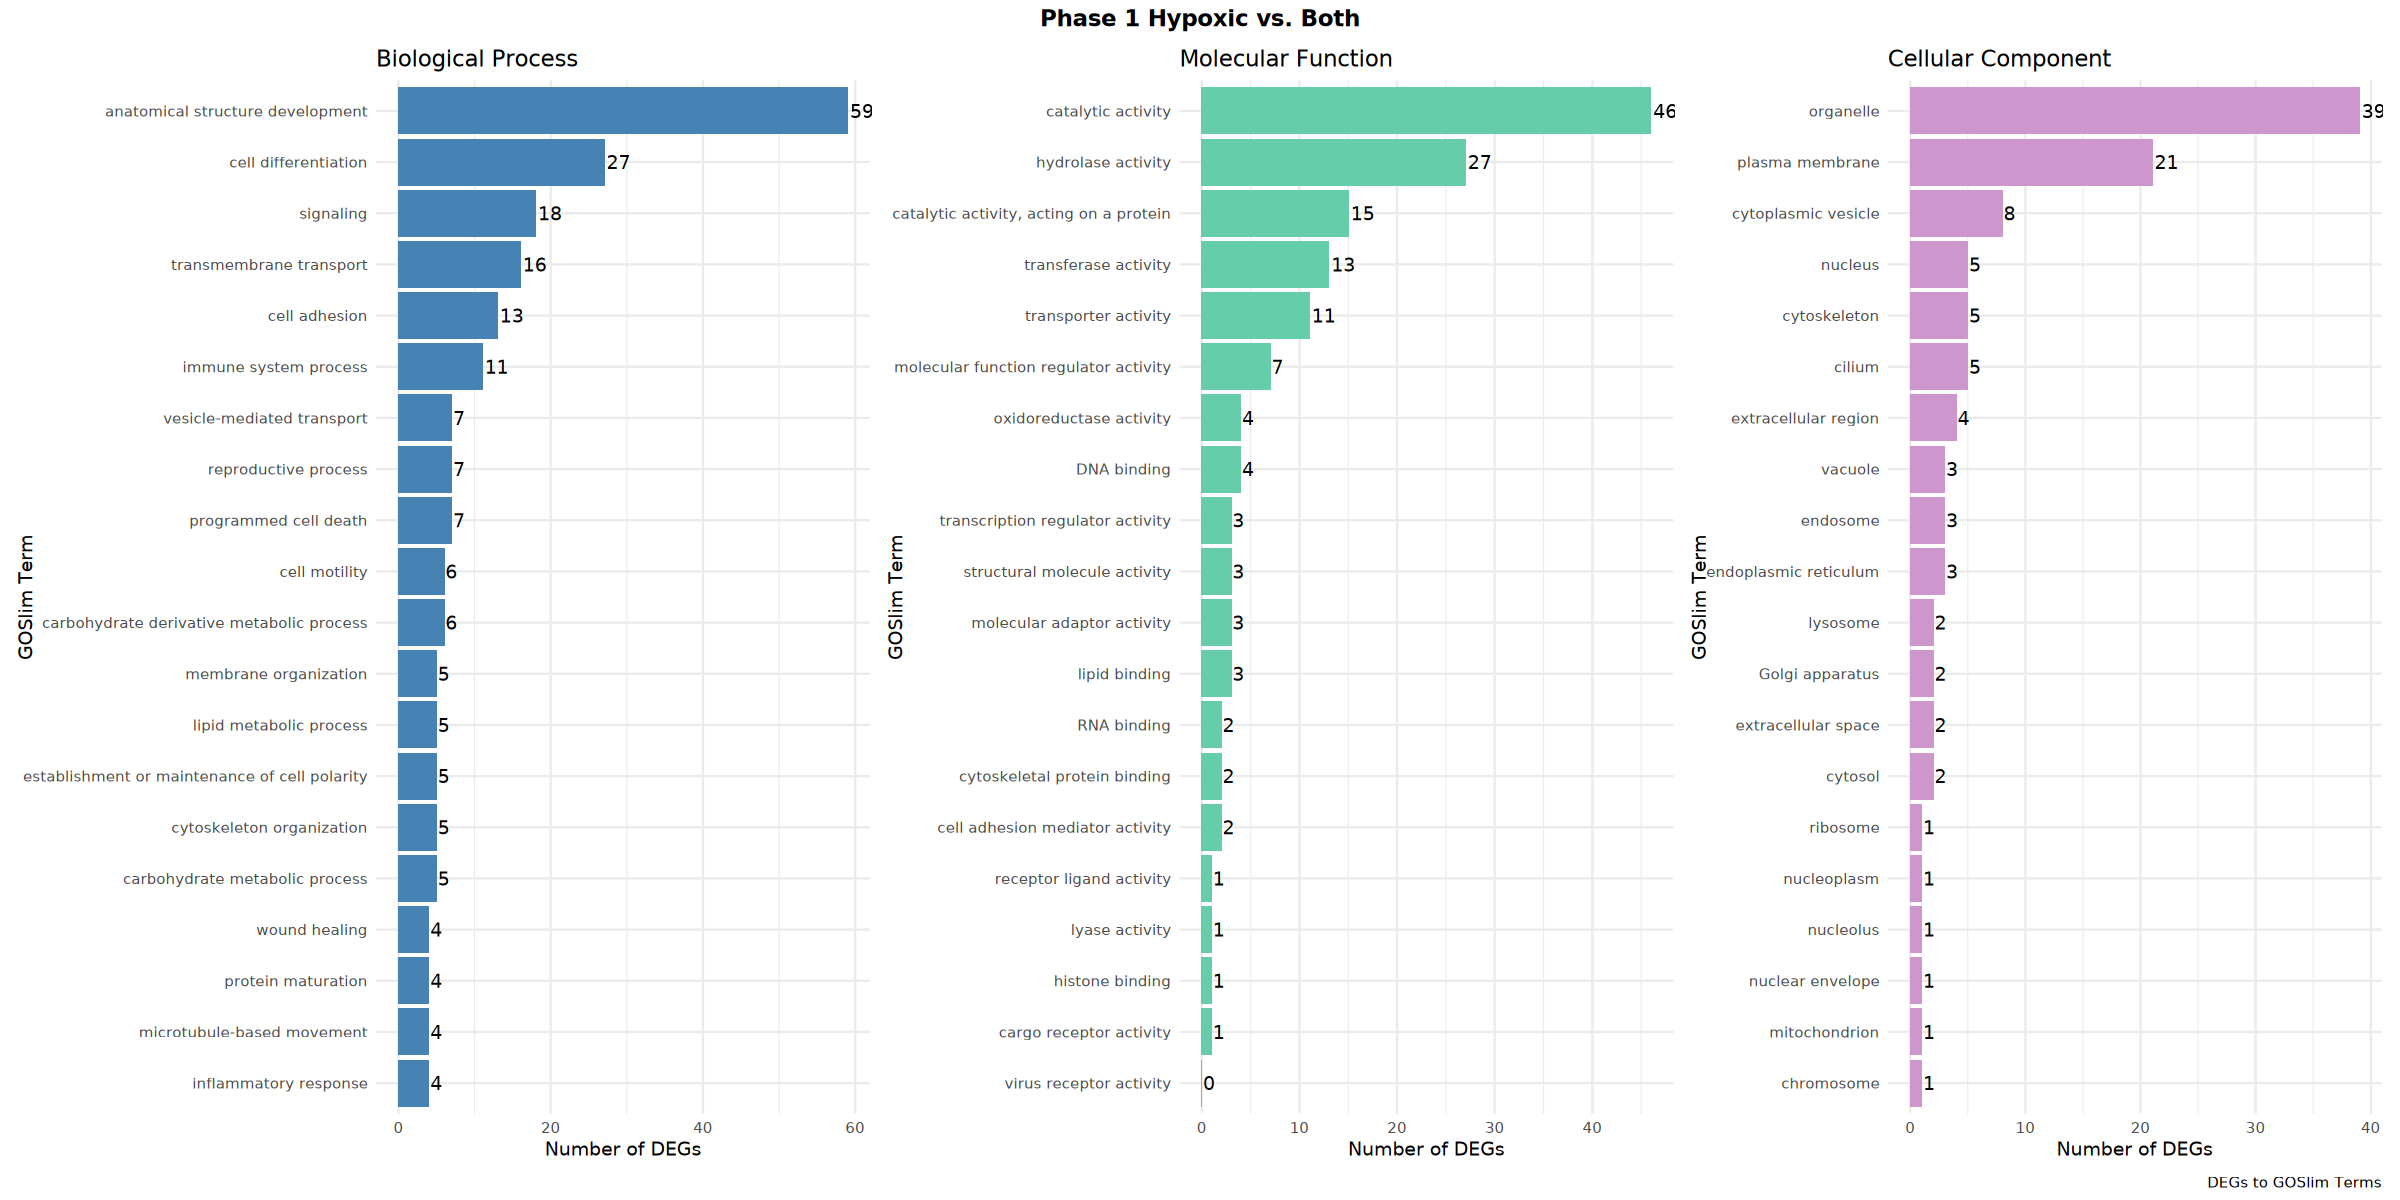

In [64]:
options(repr.plot.width=20, repr.plot.height=10)

hb.bp.topPlot <- ggplot(hb.BP.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Biological Process",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

hb.mf.topPlot <- ggplot(hb.MF.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "aquamarine3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Molecular Function",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

hb.cc.topPlot <- ggplot(hb.CC.top20, aes(x = reorder(Term, Count), y = Count)) +
  geom_col(fill = "plum3") +
  geom_text(aes(label = Count), hjust = -0.1) +
  coord_flip() +
  labs(
    title = "Cellular Component",
    x = "GOSlim Term",
    y = "Number of DEGs"
  ) +
  theme_minimal()

hb.bp.topPlot + hb.mf.topPlot + hb.cc.topPlot + plot_annotation('Phase 1 Hypoxic vs. Both',
                                                                caption = 'DEGs to GOSlim Terms',
                                                                theme=theme(plot.title=element_text(face = "bold",
                                                                                                    hjust=0.5)))

## Upset Plots
to look for unique/shared GOslim terms

In [63]:
library(UpSetR)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the UpSetR package.
  Please report the issue to the authors.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the UpSetR package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the UpSetR package.
  Please report the issue to the authors.”


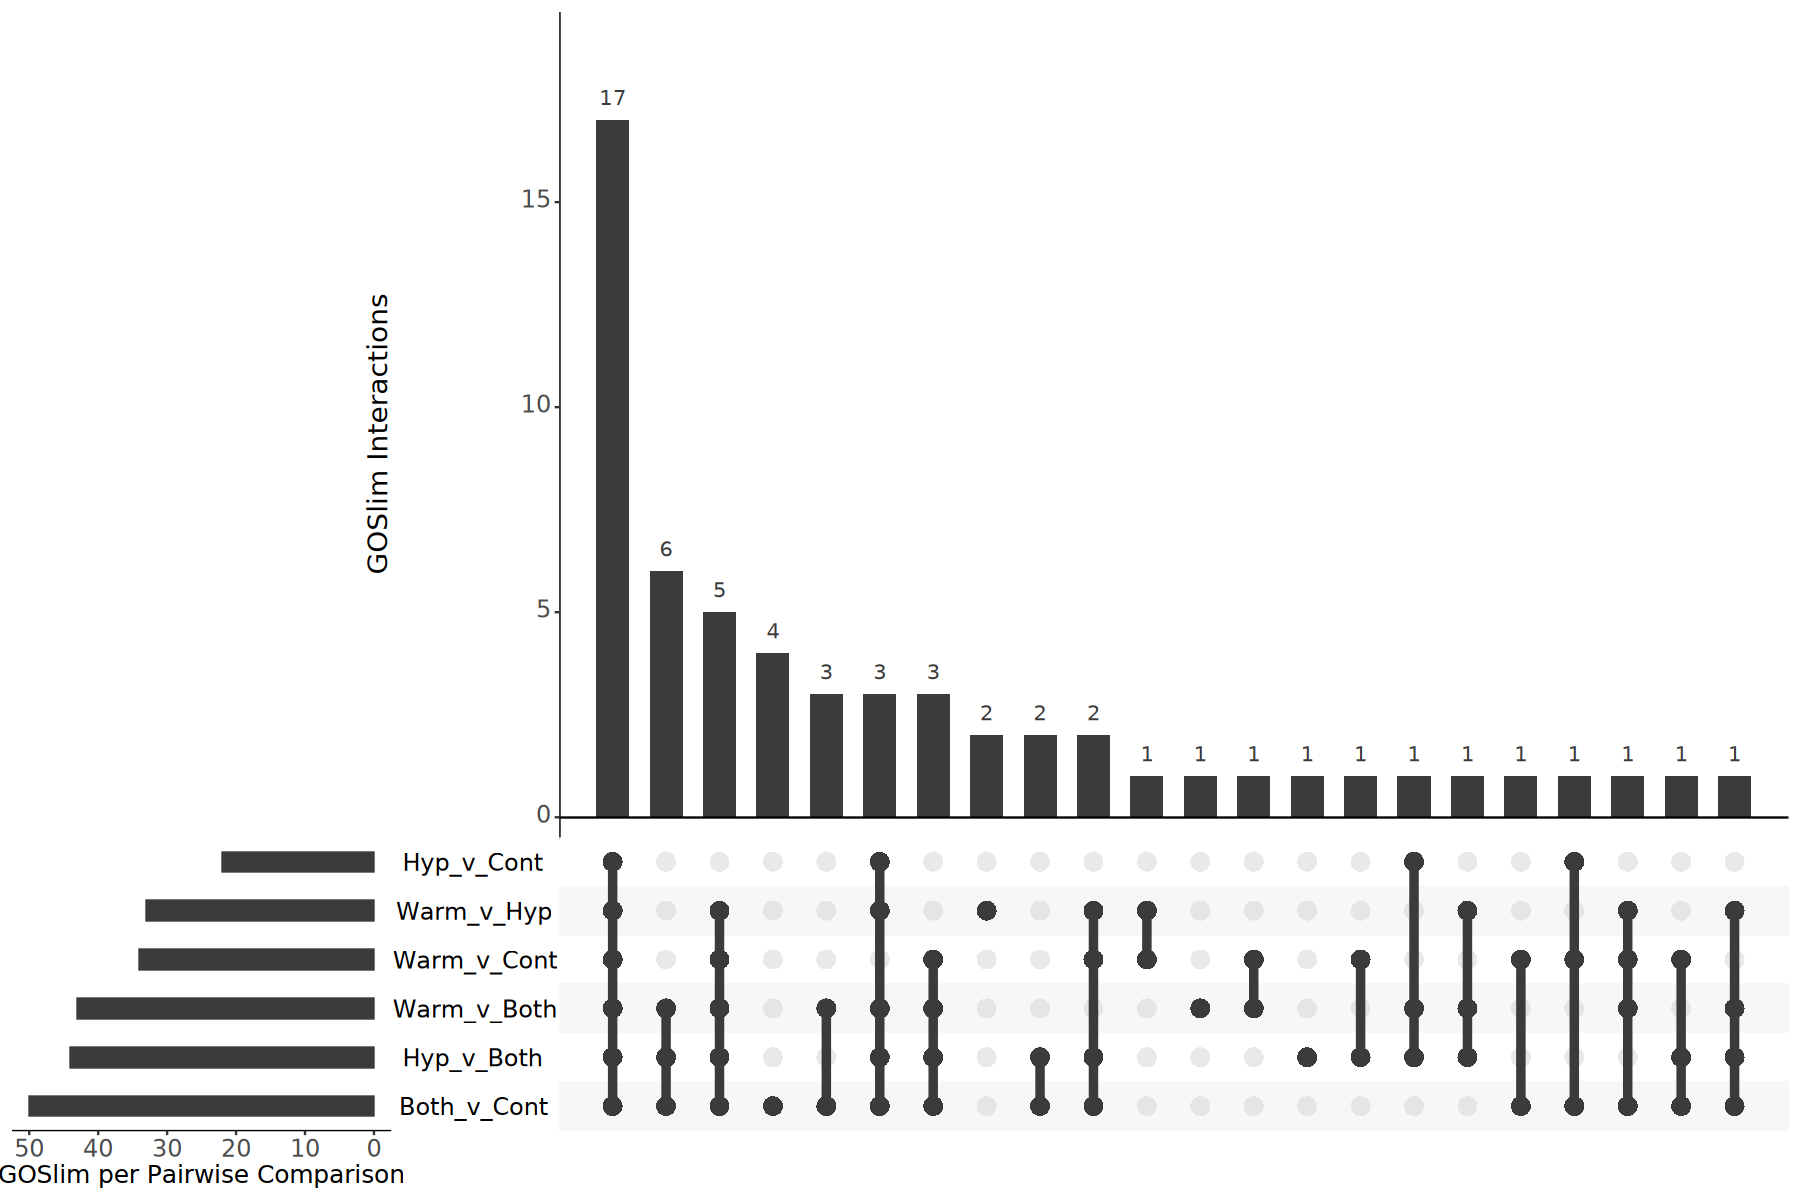

In [64]:
options(repr.plot.width=15, repr.plot.height=10)

all_list = list(Hyp_v_Both = h.b_goSlim$Term,
              Warm_v_Both = w.b_goSlim$Term,
              Warm_v_Hyp = w.h_goSlim$Term,
               Hyp_v_Cont = h.c_goSlim$Term,
               Warm_v_Cont = w.c_goSlim$Term,
               Both_v_Cont = b.c_goSlim$Term)

upset(fromList(all_list), nsets = 6,, order.by='freq', point.size = 5, line.size = 2, 
    mainbar.y.label = "GOSlim Interactions", sets.x.label = "GOSlim per Pairwise Comparison", 
    text.scale = c(2, 2, 1.75, 2, 2, 2))

maybe this isn't that informative since GOSlim terms are generally more broad, so it's likely the different comparisons are going to share GOSlim terms - this doesn't take into account any counts for the different terms, so it's likely that these comparisons differ by the most abundant term

### `gene2goSlim` function expanded
code below is taken directly from [Roberts Lab workflow](https://robertslab.github.io/resources/bio-Annotation/)

this is for **both vs. control**

In [30]:
# Column names corresponding to gene name/ID and GO IDs
GO.ID.column <- "Gene.Ontology.IDs"
gene.ID.column <- "gene_id"

# Relative path or URL to input file
### BOTH vs. CONTROL
input.file <- b.c_go

##### Official GO info - no need to change #####
goslims_obo <- "goslim_generic.obo"
goslims_url <- "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"


In [31]:
# Find GSEAbase installation location
gseabase_location <- find.package("GSEABase")

# Load path to GOslim OBO file
goslim_obo_destintation <- file.path(gseabase_location, "extdata", goslims_obo, fsep = "/")

# Download the GOslim OBO file
download.file(url = goslims_url, destfile = goslim_obo_destintation)

# Loads package files
gseabase_files <- system.file("extdata", goslims_obo, package="GSEABase")


In [32]:
# read in gene file
#full.gene.df <- read.csv(file = input.file, header = TRUE, sep = ",")
full.gene.df <- b.c_go
str(full.gene.df)

'data.frame':	305 obs. of  2 variables:
 $ gene_id          : chr  "LOC111119645" "LOC111111234" "LOC111104630" "LOC111100092" ...
 $ Gene.Ontology.IDs: chr  NA "GO:0003677; GO:0003723; GO:0003887; GO:0003964; GO:0004190; GO:0004519; GO:0005634; GO:0005737; GO:0006310; GO:"| __truncated__ NA "GO:0004674; GO:0005516; GO:0005524; GO:0008344; GO:0018105; GO:0018107; GO:0019901; GO:0031672; GO:0035095; GO:"| __truncated__ ...


In [33]:
# Clean whitespace, filter NA/empty rows, select columns, and split GO terms using column name variables
gene.GO.df <- full.gene.df %>%
  mutate(!!GO.ID.column := str_replace_all(.data[[GO.ID.column]], "\\s*;\\s*", ";")) %>% # Clean up spaces around ";"
  filter(!is.na(.data[[gene.ID.column]]) & !is.na(.data[[GO.ID.column]]) & .data[[GO.ID.column]] != "") %>% 
  select(all_of(c(gene.ID.column, GO.ID.column)))


str(gene.GO.df)

'data.frame':	127 obs. of  2 variables:
 $ gene_id          : chr  "LOC111111234" "LOC111100092" "LOC111130465" "LOC111136934" ...
 $ Gene.Ontology.IDs: chr  "GO:0003677;GO:0003723;GO:0003887;GO:0003964;GO:0004190;GO:0004519;GO:0005634;GO:0005737;GO:0006310;GO:0006508;G"| __truncated__ "GO:0004674;GO:0005516;GO:0005524;GO:0008344;GO:0018105;GO:0018107;GO:0019901;GO:0031672;GO:0035095;GO:0040017;G"| __truncated__ "GO:0001707;GO:0005783;GO:0005794;GO:0006004;GO:0008417;GO:0010468;GO:0010717;GO:0036065;GO:0036066;GO:0046922;G"| __truncated__ "GO:0000976;GO:0000977;GO:0000978;GO:0000981;GO:0001228;GO:0003309;GO:0003310;GO:0003311;GO:0005634;GO:0006357;G"| __truncated__ ...


In [34]:
# flatten file
flat.gene.GO.df <- gene.GO.df %>% separate_rows(!!sym(GO.ID.column), sep = ";")

str(flat.gene.GO.df)

tibble [1,481 × 2] (S3: tbl_df/tbl/data.frame)
 $ gene_id          : chr [1:1481] "LOC111111234" "LOC111111234" "LOC111111234" "LOC111111234" ...
 $ Gene.Ontology.IDs: chr [1:1481] "GO:0003677" "GO:0003723" "GO:0003887" "GO:0003964" ...


In [35]:
# group genes by GO.ID
grouped.gene.GO.df <- flat.gene.GO.df %>%
  group_by(!!sym(GO.ID.column)) %>%
  summarise(!!gene.ID.column := paste(.data[[gene.ID.column]], collapse = ","))

str(grouped.gene.GO.df)

tibble [900 × 2] (S3: tbl_df/tbl/data.frame)
 $ Gene.Ontology.IDs: chr [1:900] "GO:0000002" "GO:0000016" "GO:0000030" "GO:0000118" ...
 $ gene_id          : chr [1:900] "LOC111100760,LOC111113658" "LOC111136394" "LOC111131556" "LOC111106189" ...


In [36]:
# Vector of GO IDs
go_ids <- grouped.gene.GO.df[[GO.ID.column]]

str(go_ids)

 chr [1:900] "GO:0000002" "GO:0000016" "GO:0000030" "GO:0000118" ...


In [37]:
# create new OBO collection object of just GOslims, based on provided GO IDs
# Create GSEAbase GOCollection using `go_ids`
myCollection <- GOCollection(go_ids)

# Retrieve GOslims from GO OBO file set
slim <- getOBOCollection(gseabase_files)

str(slim)

Formal class 'OBOCollection' [package "GSEABase"] with 7 slots
  ..@ .stanza     :'data.frame':	153 obs. of  1 variable:
  .. ..$ value: chr [1:153] "Root" "Term" "Term" "Term" ...
  ..@ .subset     :'data.frame':	22 obs. of  1 variable:
  .. ..$ value: chr [1:22] "Rhea list of ChEBI terms representing the major species at pH 7.3." "Term not to be used for direct annotation" "Terms planned for obsoletion" "AGR slim" ...
  ..@ .kv         :'data.frame':	2132 obs. of  3 variables:
  .. ..$ stanza_id: chr [1:2132] ".__Root__" ".__Root__" ".__Root__" ".__Root__" ...
  .. ..$ key      : chr [1:2132] "format-version" "data-version" "synonymtypedef" "synonymtypedef" ...
  .. ..$ value    : chr [1:2132] "1.2" "go/releases/2025-10-10/subsets/goslim_generic.owl" "syngo_official_label \"label approved by the SynGO project\"" "systematic_synonym \"Systematic synonym\" EXACT" ...
  ..@ evidenceCode: chr [1:26] "EXP" "IDA" "IPI" "IMP" ...
  ..@ ontology    : chr NA
  ..@ ids         : chr [1:141] "G

In [38]:
# Retrieve Biological Process (BP) GOslims
slimdf <- goSlim(myCollection, slim, "BP", verbose)
str(slimdf)

'data.frame':	72 obs. of  3 variables:
 $ Count  : int  4 2 0 22 6 1 0 0 8 0 ...
 $ Percent: num  0.846 0.423 0 4.651 1.268 ...
 $ Term   : chr  "mitotic cell cycle" "cytokinesis" "cytoplasmic translation" "immune system process" ...


### 2. Perform mapping

In [39]:
# List of GOslims and all GO IDs from `go_ids`
gomap <- as.list(GOBPOFFSPRING[rownames(slimdf)])

# Maps `go_ids` to matching GOslims
mapped <- lapply(gomap, intersect, ids(myCollection))

# Append all mapped GO IDs to `slimdf`
# `sapply` needed to apply paste() to create semi-colon delimited values
slimdf$GO.IDs <- sapply(lapply(gomap, intersect, ids(myCollection)), paste, collapse=";")

# Remove "character(0) string from "GO.IDs" column
slimdf$GO.IDs[slimdf$GO.IDs == "character(0)"] <- ""

# Add self-matching GOIDs to "GO.IDs" column, if not present
for (go_id in go_ids) {
  # Check if the go_id is present in the row names
  if (go_id %in% rownames(slimdf)) {
    # Check if the go_id is not present in the GO.IDs column
    # Also removes white space "trimws()" and converts all to upper case to handle
    # any weird, "invisible" formatting issues.
    if (!go_id %in% trimws(toupper(strsplit(slimdf[go_id, "GO.IDs"], ";")[[1]]))) {
      # Append the go_id to the GO.IDs column with a semi-colon separator
      if (length(slimdf$GO.IDs) > 0 && nchar(slimdf$GO.IDs[nrow(slimdf)]) > 0) {
        slimdf[go_id, "GO.IDs"] <- paste0(slimdf[go_id, "GO.IDs"], "; ", go_id)
      } else {
        slimdf[go_id, "GO.IDs"] <- go_id
      }
    }
  }
}

str(slimdf)

'data.frame':	72 obs. of  4 variables:
 $ Count  : int  4 2 0 22 6 1 0 0 8 0 ...
 $ Percent: num  0.846 0.423 0 4.651 1.268 ...
 $ Term   : chr  "mitotic cell cycle" "cytokinesis" "cytoplasmic translation" "immune system process" ...
 $ GO.IDs : chr  "GO:0000281;GO:1902983;GO:1903469;GO:1990426" "GO:0000281;GO:0032465" "" "GO:0002232;GO:0002407;GO:0002638;GO:0002735;GO:0002753;GO:0006955;GO:0030888;GO:0031295;GO:0034145;GO:0035011;G"| __truncated__ ...


In [40]:
# "Flatten" file so each row is single GO ID with corresponding GOslim
# rownames_to_column needed to retain row name info
slimdf_separated <- as.data.frame(slimdf %>%
  rownames_to_column('GOslim') %>%
  separate_rows(GO.IDs, sep = ";"))

# Group by unique GO ID
grouped_slimdf <- slimdf_separated %>%
  filter(!is.na(GO.IDs) & GO.IDs != "") %>%
  group_by(GO.IDs) %>%
  summarize(GOslim = paste(GOslim, collapse = ";"),
            Term = paste(Term, collapse = ";"))


str(grouped_slimdf)

tibble [354 × 3] (S3: tbl_df/tbl/data.frame)
 $ GO.IDs: chr [1:354] " GO:0002376" " GO:0005975" " GO:0006281" " GO:0006310" ...
 $ GOslim: chr [1:354] "GO:0002376" "GO:0005975" "GO:0006281" "GO:0006310" ...
 $ Term  : chr [1:354] "immune system process" "carbohydrate metabolic process" "DNA repair" "DNA recombination" ...


In [41]:
slimdf.sorted <- slimdf %>% arrange(desc(Count))

b.c.slim.count.df <- slimdf.sorted %>% 
  select(Term, Count)

str(b.c.slim.count.df)

'data.frame':	72 obs. of  2 variables:
 $ Term : chr  "anatomical structure development" "cell differentiation" "signaling" "immune system process" ...
 $ Count: int  107 47 41 22 20 20 17 17 15 12 ...


In [42]:
head(b.c.slim.count.df)

,Term,Count
,<chr>,<int>
GO:0048856,anatomical structure development,107
GO:0030154,cell differentiation,47
GO:0023052,signaling,41
GO:0002376,immune system process,22
GO:0055085,transmembrane transport,20
GO:1901135,carbohydrate derivative metabolic process,20
